## IMPORTING LIBRARIES AND READING THE DATA

In [53]:
# IMPORTING LIBRARIES 
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers,models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings("ignore")
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
import c_writer
from os.path import join

In [54]:
# Reading the data and making it into a meaningful dataframe
data = pd.read_csv("Network_anomaly_data.txt",sep=",",names=["duration","protocoltype","service",
"flag","srcbytes","dstbytes","land", "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised",
"rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles","numoutboundcmds","ishostlogin",
"isguestlogin","count","srvcount","serrorrate", "srvserrorrate","rerrorrate","srvrerrorrate","samesrvrate", 
"diffsrvrate", "srvdiffhostrate","dsthostcount","dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate",
"dsthostsamesrcportrate","dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate","dsthostrerrorrate",
"dsthostsrvrerrorrate","attack", "lastflag"])

In [55]:
data # printing the dataframe

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


## DATA PREPROCESSING AND GETTING THE TEST AND TRAIN DATA

In [56]:
# We are dropping certain features that we feel arent required for our process
data.drop(['land','urgent','numfailedlogins','numoutboundcmds'],axis=1,inplace=True)

In [57]:
# Since normal datas are labelled as "normal" but attacks are given by the attack type which we aren't concerned 
# about as of now as we need to know if it is an attack or not so all the labels apart from normal we are changing it to 
# "attack"
data['attack'].loc[data['attack']!='normal']='attack'
data

,duration,protocoltype,service,flag,srcbytes,dstbytes,wrongfragment,hot,loggedin,numcompromised,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,attack,19
3,0,tcp,http,SF,232,8153,0,0,1,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,1,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,attack,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,1,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,attack,20


In [58]:
# label encoding non-numerical attributes
le=LabelEncoder()
data['protocoltype'] = le.fit_transform(data['protocoltype'])
data['service'] = le.fit_transform(data['service'])
data['flag'] = le.fit_transform(data['flag'])
data['attack'] = le.fit_transform(data['attack'])
pd.DataFrame(data)

,duration,protocoltype,service,flag,srcbytes,dstbytes,wrongfragment,hot,loggedin,numcompromised,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1,20
1,0,2,44,9,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1,15
2,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,19
3,0,1,24,9,232,8153,0,0,1,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1,21
4,0,1,24,9,199,420,0,0,1,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,49,5,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0,20
125969,8,2,49,9,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,1,21
125970,0,1,54,9,2231,384,0,0,1,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,1,18
125971,0,1,30,5,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,20


In [59]:
# All the features apart from Attack are what we are going to use to predict the attack status of the data
# attack = 1 (normal/not an attack) and attack = 0 (attack)
X = data.drop(['attack'],axis=1).to_numpy()
Y = data['attack'].to_numpy()
# Splitting X and y testing and training data
# we are taking 20% of the data for testing and 80% of the data for training 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20)
# reshaping y test and train array
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)
# Getting input and output layer dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
# To store the accuracies of the two models to later find which model is better for our project
model_acc = []
our_models = []

## TESTING AND TRAINING OUR NEURAL NETWORK MODELS 

In [60]:
# function definition for auto-encoder model
def autoen_model(X_train, X_test, y_train, y_test ):
    
    # encoding dimensions
    encoding_dim = 16
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(1e-5))(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = Dense(output_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    # no of epochs = number times that the learning algorithm will work through the entire training dataset.
    nb_epoch = 10
    # batch size
    b_size = 32
    # Configuring and compiling the model using adam optimizer (stochastic gradient descent method that is 
    # based on adaptive estimation of first-order and second-order moments) and mean_squared_error loss
    # (MSE is the sum of squared distances between our target variable and predicted values)
    autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
    # Estimate sample weights by class for unbalanced datasets.
    cws = class_weight.compute_sample_weight("balanced", y_train)
    weight = {i : cws[i] for i in range(len(np.unique(y_train)))}
    # Fitting the model
    autoencoder.fit(X_train, y_train,class_weight = weight,epochs=nb_epoch,batch_size = b_size)
    # Predicting 
    predictions = autoencoder.predict(X_test)
    # Converting from float to int
    pred = predictions.astype(int)
    # Confusion matrix heatmap
    conf_matrix = confusion_matrix(y_test,pred)
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
    # The top and bottom of heatmap gets trimmed off so to prevent that we set ylim
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Confusion matrix")
    plt.show()
    # Calculating root mean square error
    rmse = np.sqrt(np.mean(((pred - y_test) ** 2)))
    print("ROOT MEAN SQUARE ERROR")
    print(rmse)
    print("ACCURACY")
    # Appending model accuracy and model object for later use 
    model_acc.append(accuracy_score(y_test,pred))
    our_models.append(autoencoder)
    print(accuracy_score(y_test,pred))

In [61]:
# function definition for a basic NN (neural network)
def dnn_model(X_train,X_test,y_train,y_test):
    
    #Defining a sequential model with 3 layers
    model = tf.keras.models.Sequential([
    Dense(units = 16, input_shape =(input_dim,),activation = 'relu'),
    Dense(units = 16, activation = 'relu'),
    Dense(units = 2, activation = 'softmax')])
    # Compiling the NN with adam optimizer and sparse_categorical_crossentropy loss
    model.compile(optimizer = "adam",loss = "sparse_categorical_crossentropy",metrics=["accuracy"])
    # Fitting the training data 
    model.fit(X_train,y_train, epochs = 10,batch_size=32)
    # Predicting 
    prediction = model.predict(X_test,verbose = 0)
    # since our predictions here will be probabilites, the class with the maximum probability 
    # will be the prediction     
    y_pred = np.argmax(prediction,axis = -1)
    # Confusion matrix heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
    # The top and bottom of heatmap gets trimmed off so to prevent that we set ylim
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Confusion matrix")
    plt.show()
    pred = y_pred.astype(int)
    # Calculating root mean square error
    rmse = np.sqrt(np.mean(((pred - y_test) ** 2)))
    print("ROOT MEAN SQUARE ERROR")
    print(rmse)
    print("ACCURACY")
     # Appending model accuracy and model object for later use
    model_acc.append(accuracy_score(y_test,pred))
    our_models.append(model)
    print(accuracy_score(y_test,pred))

Epoch 1/10
3150/3150 [==============================] - 3s 703us/step - loss: 0.0790 - accuracy: 0.9066
Epoch 2/10
3150/3150 [==============================] - 2s 721us/step - loss: 0.0300 - accuracy: 0.9601
Epoch 3/10
3150/3150 [==============================] - 2s 705us/step - loss: 0.0262 - accuracy: 0.9639
Epoch 4/10
3150/3150 [==============================] - 2s 721us/step - loss: 0.0261 - accuracy: 0.9639
Epoch 5/10
3150/3150 [==============================] - 2s 721us/step - loss: 0.0225 - accuracy: 0.9744
Epoch 6/10
3150/3150 [==============================] - 2s 738us/step - loss: 0.0196 - accuracy: 0.9765
Epoch 7/10
3150/3150 [==============================] - 2s 734us/step - loss: 0.0165 - accuracy: 0.9789
Epoch 8/10
3150/3150 [==============================] - 2s 737us/step - loss: 0.0207 - accuracy: 0.9764
Epoch 9/10
3150/3150 [==============================] - 2s 741us/step - loss: 0.0171 - accuracy: 0.9804
Epoch 10/10
3150/3150 [==============================] - 2s 737u

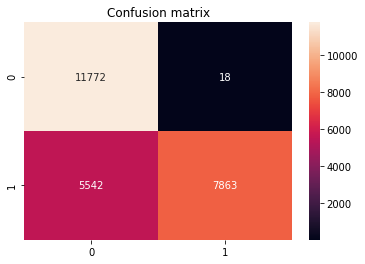

ROOT MEAN SQUARE ERROR
0.46976452196018237
ACCURACY
0.7793212939075214


In [62]:
#calling the auto encoder model for our testing and training data 
autoen_model(X_train,X_test,y_train,y_test)

Epoch 1/10
3150/3150 [==============================] - 3s 761us/step - loss: 778.4836 - accuracy: 0.8241
Epoch 2/10
3150/3150 [==============================] - 3s 878us/step - loss: 449.8283 - accuracy: 0.8982
Epoch 3/10
3150/3150 [==============================] - 3s 992us/step - loss: 212.7421 - accuracy: 0.9112
Epoch 4/10
3150/3150 [==============================] - 3s 1ms/step - loss: 426.8570 - accuracy: 0.9277
Epoch 5/10
3150/3150 [==============================] - 3s 1ms/step - loss: 780.0569 - accuracy: 0.8890
Epoch 6/10
3150/3150 [==============================] - 3s 817us/step - loss: 1260.6344 - accuracy: 0.8490
Epoch 7/10
3150/3150 [==============================] - 3s 872us/step - loss: 972.8510 - accuracy: 0.9384: 1s - loss: 1175.
Epoch 8/10
3150/3150 [==============================] - 3s 824us/step - loss: 140.6450 - accuracy: 0.9281
Epoch 9/10
3150/3150 [==============================] - 3s 910us/step - loss: 459.0557 - accuracy: 0.8134
Epoch 10/10
3150/3150 [========

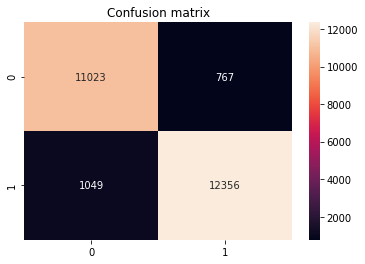

ROOT MEAN SQUARE ERROR
0.7061607790194918
ACCURACY
0.9279222067870609


In [63]:
#calling the basic NN model for our testing and training data 
dnn_model(X_train,X_test,y_train,y_test)

In [64]:
# Model accuracies 
model_names = ["AUTOENCODER","DNN"]
df_acc = pd.DataFrame(list(zip(model_names,model_acc)))
df_acc.rename(columns = {0:'MODEL',1:'ACCURACY'},inplace=True)
df_acc

,MODEL,ACCURACY
0,AUTOENCODER,0.779321
1,DNN,0.927922


## TINYML

In [65]:
# getting best model object based off max accuracy
best_model = our_models[model_acc.index(max(model_acc))]
# Convert to tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the model in .tflite format
with open('network_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\deept\AppData\Local\Temp\tmpluzyke2_\assets


INFO:tensorflow:Assets written to: C:\Users\deept\AppData\Local\Temp\tmpluzyke2_\assets


In [66]:
# Converting tflite_model to C  
# c_writer is a py file in the same folder and has been imported at the beginning of the notebook
# Reference : https://github.com/ShawnHymel/tinyml-example-anomaly-detection/blob/master/utils/c_writer.py
# Weuse #04x to pad the output to 2 digits with a 0x prefix
hex_array = [format(val, '#04x') for val in tflite_model]
# Calling function to convert an array into a C string (requires Numpy) 
# create_array(np_array, var_type, var_name, line_limit=80, indent=4)
c_model = c_writer.create_array(np.array(hex_array), 'unsigned char', "network_model")
# Calling Function to create a header file with given C code as a string
header_str = c_writer.create_header(c_model, "network_model")

In [67]:
#Writing to the header file
with open(join("C:\\Users\\deept\\Desktop\\Sem 4\\Sem4 Projects\\CN Project", "network_model") + '.h', 'w') as file:
    file.write(header_str)

In [68]:
# Converting a sample piece of the X test and y test data to C (for the purpose of ino code (arduino) to load and test 
# the sample and compare with our python output

Xtest = X_test[0:5,:]
print(c_writer.create_array(Xtest,"float","X_test"))

const unsigned int X_test_dim1 = 5;
const unsigned int X_test_dim2 = 38;

const float X_test[5][38] = {
    0.0, 1.0, 24.0, 9.0, 222.0, 25804.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 
    0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 44.0, 0.0, 0.0, 0.02, 0.02, 1.0, 0.0, 0.0, 
    93.0, 255.0, 1.0, 0.0, 0.02, 0.03, 0.0, 0.0, 0.01, 0.01, 21.0, 0.0, 1.0, 
    49.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
    0.0, 140.0, 15.0, 0.0, 0.0, 1.0, 1.0, 0.11, 0.07, 0.0, 255.0, 15.0, 0.06, 
    0.08, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 21.0, 3.0, 1.0, 18.0, 9.0, 6.0, 28.0, 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 511.0, 1.0, 
    0.07, 0.0, 0.91, 0.0, 0.0, 1.0, 0.0, 255.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.1, 
    0.0, 0.87, 0.0, 12.0, 0.0, 2.0, 12.0, 9.0, 42.0, 128.0, 0.0, 0.0, 0.0, 0.0, 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 144.0, 0.0, 0.0, 0.0, 0.0, 
    1.0, 0.0, 0.01, 255.0, 242.0, 0.95, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
    20.0, 0.0, 2.0, 44.0, 9.0, 

In [69]:
ytest=y_test[0:5]
print(c_writer.create_array(ytest,"uint8_t","y_test"))

const unsigned int y_test_dim1 = 5;
const unsigned int y_test_dim2 = 1;

const uint8_t y_test[5][1] = {
    1, 0, 0, 1, 1
};



## REFERENCES

### 1. https://www.kaggle.com/aaryanverma/anamoly-detection-with-82-accuracy-on-test-data/comments
### 2. https://eloquentarduino.github.io/2021/03/tinyml-classification-example-wine-dataset/
### 3. https://github.com/ShawnHymel/tinyml-example-anomaly-detection
### 4. TinyML: Machine Learning with TensorFlow Lite on Arduino and Ultra-Low-Power Microcontrollers